In [ ]:
!pip install PyWavelets
!pip install pyts
!pip install aeon
!pip install "dask[dataframe]"

In [3]:
import os

import aeon
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import pywt
from scipy import signal
from pyts.image import MarkovTransitionField
from pyts.image import GramianAngularField
from pyts.image import RecurrencePlot
from PIL import Image
from datetime import datetime


from sklearn.metrics import accuracy_score
from sklearn.linear_model import RidgeClassifierCV

from aeon.transformations.collection.convolution_based import Rocket, MiniRocket
from aeon.datasets import load_from_ts_file

In [8]:
# função para normalizar as séries na mesma escala
# a série ficará com uma média próxima de 0 e desvio-padrão próximo de 1
def znorm(x):
  x_znorm = (x - np.mean(x)) / np.std(x)
  return x_znorm


# função que transforma uma série de entrada em uma imagem em 2D.
# transformações que serão exploradas: CWT, MTF, GADF, GASF, RP e FIRTS
# referência para entender um pouco melhor: https://pyts.readthedocs.io/en/stable/modules/image.html
def transform_series(series, representation):
  series = np.array(znorm(series))
  if representation == "CWT":
    coeffs, freqs = pywt.cwt(series, scales=np.arange(1, len(series) + 1), wavelet='morl') # morl
    im_final = coeffs
  elif representation == "MTF":
    series = series.reshape(1, len(series))
    mtf = MarkovTransitionField(strategy='normal') #n_bins=4, strategy='uniform'
    X_mtf = mtf.fit_transform(series)
    im_final = X_mtf[0]
  elif representation == "GADF":
    series = series.reshape(1, len(series))
    gaf = GramianAngularField(method='difference')
    X_gaf = gaf.fit_transform(series)
    im_final = X_gaf[0]
  elif representation == "GASF":
    series = series.reshape(1, len(series))
    gaf = GramianAngularField(method='summation')
    X_gaf = gaf.fit_transform(series)
    im_final = X_gaf[0]
  elif representation == "RP":
    series = series.reshape(1, len(series))
    rp = RecurrencePlot(threshold='distance')
    X_rp = rp.fit_transform(series)
    im_final = X_rp[0]
  elif representation == "FIRTS":
    series = series.reshape(1, len(series))
    mtf = MarkovTransitionField(n_bins=4, strategy='uniform')
    X_mtf = mtf.fit_transform(series)
    gaf = GramianAngularField(method='difference')
    X_gaf = gaf.fit_transform(series)
    rp = RecurrencePlot(threshold='distance')
    X_rp = rp.fit_transform(series)
    im_final = (X_mtf[0] + X_gaf[0] + X_rp[0]) # FIRTS é fusão entre MTF, GADF e RP (vejam o artigo que passei para vocês)
  return im_final

In [23]:
# como carregar os dados de treino/teste de um conjunto de dados nas variáveis X_train, y_train, X_test, y_test

dataset = 'FaceDetection'

DATA_PATH = "C:/Users/bruno/puc/iniciacao/datasets/data"
X_train, y_train = load_from_ts_file(f"{DATA_PATH}/{dataset}/{dataset}_TRAIN.ts")
X_test, y_test = load_from_ts_file(f"{DATA_PATH}/{dataset}/{dataset}_TEST.ts")


# cada exemplo é multivariado, ou seja, é composto por mais de uma série temporal
# para o dataset escolhido, temos:
print(f'Quantidade de exemplos de treino: {X_train.shape[0]}')
print(f'Cada exemplo tem {X_train.shape[1]} variáveis')
print(f'Cada variável possui {X_train.shape[2]} observações')

Quantidade de exemplos de treino: 5890
Cada exemplo tem 144 variáveis
Cada variável possui 62 observações


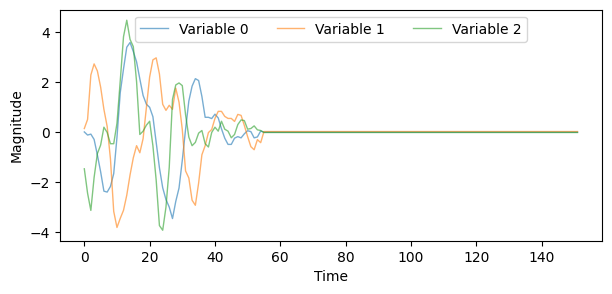

In [5]:
# vamos visualizar as N séries do 15o exemplo do conjunto de treinamento
# veja como esses exemplos são acessados para entender como gerar as imagens
plt.figure(figsize=(7,3))
for dim in range(X_train.shape[1]):
  plt.plot(X_train[15][dim], linewidth=1, alpha=0.6, label=f'Variable {dim}')

plt.xlabel('Time')
plt.ylabel('Magnitude')
plt.legend(loc="upper center", ncols=3)

#plt.savefig('rawdata.pdf', bbox_inches='tight')

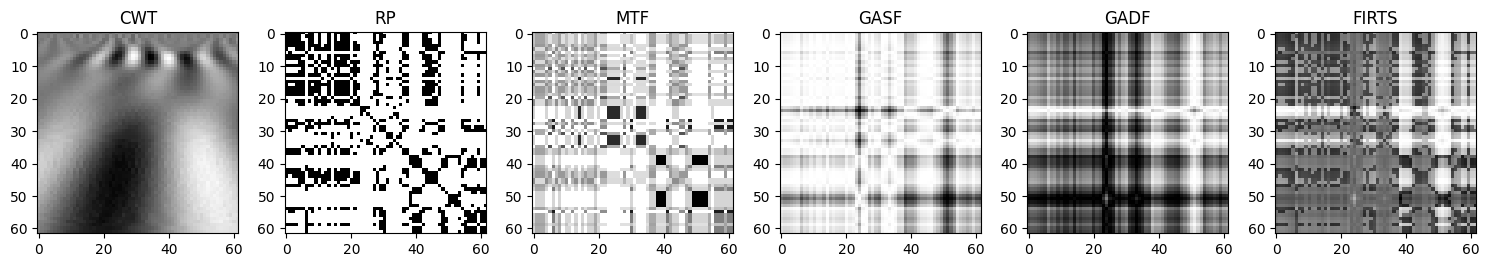

In [24]:
# vamos visualizar uma mesma série em diferentes representações 2D
reps = ['CWT', 'RP', 'MTF', 'GASF', 'GADF', 'FIRTS']
fig, axs = plt.subplots(1, len(reps), figsize=(15, 4))
pos = 0
for i in reps:
  img = transform_series(X_train[0][0], i)
  axs[pos].imshow(img, cmap='binary')
  axs[pos].set_title(i)
  plt.tight_layout()
  pos+=1

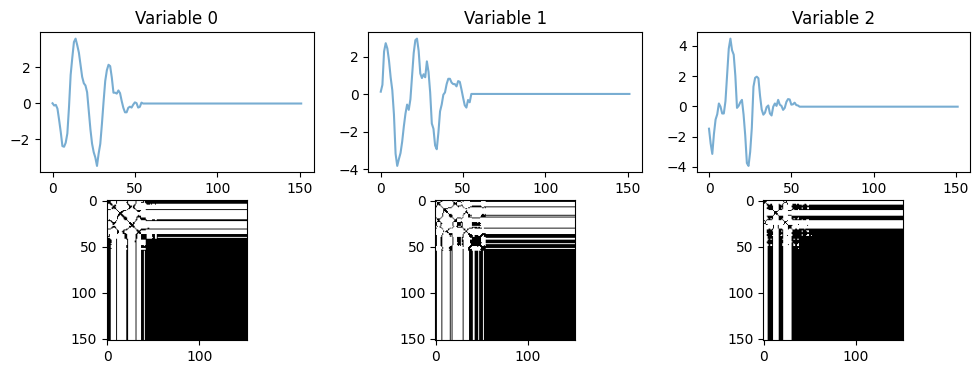

In [7]:
# vamos visualizar cada uma das variáveis de um exemplo utilizando uma representação de imagens em 2D
fig, axs = plt.subplots(2, X_train.shape[1], figsize=(12, 4))
for dim in range(X_train.shape[1]):
  axs[0, dim].plot(X_train[15][dim], alpha=0.6) # plot da série 1D no tempo
  axs[0, dim].set_title(f'Variable {dim}')
  # transforma a série em uma imagem
  img = transform_series(X_train[15][dim], 'RP') # testem mudar a representação (MTF, GASF, GADF, RP, CWT, FIRTS)
  axs[1, dim].imshow(img, cmap='binary') # plot da imagem 2D correspondente

# Projeto do BRUNO:
FUSÃO DE IMAGENS PARA CLASSIFICAÇÃO DE SÉRIES MULTIVARIADAS

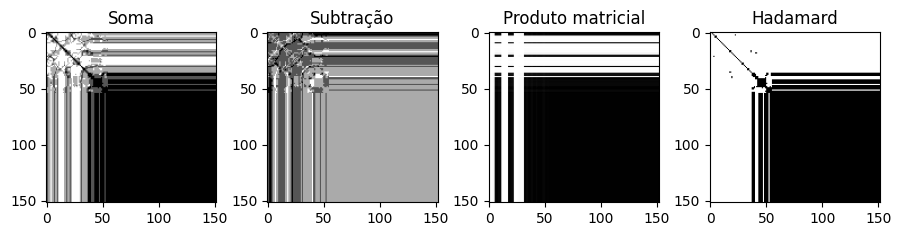

In [8]:
### ABORDAGEM DE FUSÃO DAS IMAGENS ###

# Dado que cada exemplo é composto por diferentes séries (variáveis), podemos realizar
# diferentes operações aritméticas (soma, subtração, produto) com as imagens de cada variável
# e gerar uma imagem única para representar as diferentes variáveis de um exemplo

# Gerando as imagens de cada variável para depois realizar as operações aritméticas
img_dim0 = transform_series(X_train[15][0], 'RP')
img_dim1 = transform_series(X_train[15][1], 'RP')
img_dim2 = transform_series(X_train[15][2], 'RP')

# SOMA
img_soma = img_dim0 + img_dim1 + img_dim2

# SUBTRAÇÃO
img_subtracao = img_dim0 - img_dim1 - img_dim2


# PRODUTO MATRICIAL (dot product)
img_produto = np.dot(np.dot(img_dim0, img_dim1), img_dim2)

# PRODUTO DE HADAMARD (element-wise)
img_hadamard = np.multiply(np.multiply(img_dim0, img_dim1),  img_dim2)


fig, axs = plt.subplots(1, 4, figsize=(9, 5))
axs[0].imshow(img_soma, cmap='binary')
axs[0].set_title('Soma')

axs[1].imshow(img_subtracao, cmap='binary')
axs[1].set_title('Subtração')

axs[2].imshow(img_produto, cmap='binary')
axs[2].set_title('Produto matricial')

axs[3].imshow(img_hadamard, cmap='binary')
axs[3].set_title('Hadamard')

plt.tight_layout()
#plt.savefig('fusao.pdf', bbox_inches='tight')

In [9]:
from functools import reduce
from operator import sub, add

# - precisamos escrever funções que realizam cada uma das operações aritméticas
# - a função deve receber como entrada: um conjunto de exemplos (X_train ou X_test)
# com N variáveis (no exemplo, 3 variáveis) e um tipo de representação (CWT, MTF, GASF, GADF, RP ou FIRTS)
# - a função deve gerar como saída: um conjunto de exemplos (X_train ou X_test)
# em que cada exemplo é uma matriz que representa a soma ou subtração ou produto matricial ou produto de Hadamard de N variáveis




# TODO: dividir essa função em uma que gera as imagens e outra que faz as operações sobre as imagens
def dimensions_fusion(img_dataset, operation, representation):
    # data: X_train_transformed ou X_test_transformated
    # operation: sum, subtraction, dot_product, element_wise
    # representation: CWT, RP, MTF, GASF, GADF, FIRTS
    new_data = []
    for dataset in img_dataset:
        imgs = dataset.copy()
        img_final = imgs.pop()
        for img in imgs:
            if operation == 'sum':
                img_final += img
            elif operation == 'subtraction':
                img_final -= img
            elif operation == 'dot_product':
                img_final = np.dot(img_final, img)
            elif operation == 'element_wise':
                img_final = np.multiply(img_final, img)
    
        flatten_img = img_final.flatten()
        new_data.append(flatten_img)

    return np.array(new_data)


In [10]:
from aeon.datasets import load_classification
from aeon.datasets.tsc_datasets import multivariate
import time


def load_dataset(dataset_name):
    try:
        started_at = time.time()
        print(f"Carregando {dataset_name}")
        print(f"Iniciando em {datetime.now().strftime("%Y-%m-%d %H:%M:%S")}")

        X_train, y_train = load_from_ts_file(f"{DATA_PATH}/{dataset_name}/{dataset_name}_TRAIN.ts")
        X_test, y_test = load_from_ts_file(f"{DATA_PATH}/{dataset_name}/{dataset_name}_TEST.ts")

        return {
            "X_train": X_train,
            "y_train": y_train,
            "X_test": X_test,
            "y_test": y_test,
        }
    except Exception as e:
        print(e)
        print(f"Não foi possível carregar o dataset {dataset_name} armazenados na máquina local")
        print(f"Iniciando download do dataset {dataset_name}")

        X_train, y_train = load_classification(dataset_name, split="Train")
        X_test, y_test = load_classification(dataset_name, split="Test")

        print("Download finalizado com sucesso")
    
        return {
            "X_train": X_train,
            "y_train": y_train,
            "X_test": X_test,
            "y_test": y_test,
        }
    finally:
        print(f"Tempo de carregamento: {time.time() - started_at} segundos")

In [16]:
from aeon.datasets.tsc_datasets import multivariate
list(multivariate)

['FaceDetection',
 'UWaveGestureLibrary',
 'Cricket',
 'StandWalkJump',
 'HandMovementDirection',
 'JapaneseVowels',
 'CharacterTrajectories',
 'SelfRegulationSCP1',
 'ERing',
 'RacketSports',
 'EigenWorms',
 'InsectWingbeat',
 'NATOPS',
 'ArticularyWordRecognition',
 'PEMS-SF',
 'PhonemeSpectra',
 'LSST',
 'SpokenArabicDigits',
 'Handwriting',
 'MotorImagery',
 'Libras',
 'Heartbeat',
 'DuckDuckGeese',
 'BasicMotions',
 'FingerMovements',
 'SelfRegulationSCP2',
 'PenDigits',
 'AtrialFibrillation',
 'EthanolConcentration',
 'Epilepsy']

In [ ]:
from aeon.transformations.collection.convolution_based import Rocket, MiniRocket
from aeon.datasets.tsc_datasets import multivariate
from sklearn.metrics import accuracy_score
from sklearn.linear_model import RidgeClassifierCV
from pathlib import Path

import time

reps = ['RP', 'MTF', 'GASF', 'GADF', 'FIRTS', 'CWT']
operations = ["sum", "subtraction", "dot_product", "element_wise"]

fusion_path = "D:/puc/ic/dataset/fusions"
representation_path = "D:/puc/ic/dataset/representations"

datasets_for_test = list(multivariate)[:1]

for dataset_name in datasets_for_test:
    dataset_process_started_at = time.time()
    print(f"Processando dataset {dataset_name}")
    print(f"Iniciando em {datetime.now().strftime("%Y-%m-%d %H:%M:%S")}")

    try:
        dataset_train_path = f"{representation_path}/{dataset_name}/train"
        dataset_test_path = f"{representation_path}/{dataset_name}/test"
        os.makedirs(dataset_train_path)
        os.makedirs(dataset_test_path)
        print(f"Nested directories '{dataset_train_path}' created successfully.")
        print(f"Nested directories '{dataset_test_path}' created successfully.")
    except FileExistsError:
        print(f"One or more directories in '{dataset_train_path}' already exist.")
        print(f"One or more directories in '{dataset_test_path}' already exist.")
    except Exception as e:
        print(f"An error occurred: {e}")
        
    dataset = load_dataset(dataset_name)
    X_train = dataset["X_train"]
    y_train = dataset["y_train"]
    X_test = dataset["X_test"]
    y_test = dataset["y_test"]

    for representation in reps:
        representation_transformation_started_at = time.time()
        print(f"Transformando as dimensões na representação {representation}")
        print(f"Iniciando em {datetime.now().strftime("%Y-%m-%d %H:%M:%S")}")

        transformed_train_series = []
        for exemple in X_train[:10]:
            transformed_train_series.append(
                [transform_series(series, representation) for series in exemple]
            )
        transformed_test_series = []
        """
        for exemple in X_test:
            transformed_test_series.append(
                [transform_series(series, representation) for series in exemple]
            )
        """
        print(f"Tempo de transformação: {time.time() - representation_transformation_started_at} segundos")

        for index, exemple in enumerate(transformed_train_series):
            try:
                dataset_exemple_path = f"{representation_path}/{dataset_name}/train/{index}"
                dataset_exemple_path.mkdir()
                print(f"Nested directories '{dataset_exemple_path}' created successfully.")
            except FileExistsError:
                print(f"One or more directories in '{dataset_exemple_path}' already exist.")
            except Exception as e:
                print(f"An error occurred: {e}")
            
            for index, img in enumerate(exemple):
                with open(dataset_exemple_path + str(index) + ".jpg", "w") as f:
                    print(str(img))
                    # f.write(img)
        """
        for operation in operations:
            try:
                fusion_process_started_at = time.time()
                print(f"Fundindo as dimensões na operação {operation}")
                print(f"Iniciando em {datetime.now().strftime("%Y-%m-%d %H:%M:%S")}")

                X_train_transformed = dimensions_fusion(transformed_train_series, operation, representation)
                X_test_transformed = dimensions_fusion(transformed_test_series, operation, representation)
                print(f"Tempo de fusão: {time.time() - fusion_process_started_at} segundos")

                
            except Exception as e:
                print("Problema com o dataset: " + dataset_name)
                print(e)
        """
    print(f"Tempo de processamento do dataset: {time.time() - dataset_process_started_at} segundos")


In [1]:
from aeon.transformations.collection.convolution_based import Rocket, MiniRocket
from aeon.datasets.tsc_datasets import multivariate
from sklearn.metrics import accuracy_score
from sklearn.linear_model import RidgeClassifierCV

import time

reps = ['RP', 'MTF', 'GASF', 'GADF', 'FIRTS', 'CWT']
operations = ["sum", "subtraction", "dot_product", "element_wise"]


full_results = []




# TODO: Fazer um algoritmo que faz a transformação do Rocket e outra que passa o dataset direto pro ridge
# TODO: melhorar a contagem de tempo para melhorar as analises
# Prestar atenção nas dimençoes, quanto mais bem provável que diminua a acurecia
# Prestar atenção nas acuracias do algoritmo que usa o rocket e o que não usa
# Primeiro fazer o algoritmo sem ser paralelo para depois passar ele pra geração de imagens em paralelo
# Tentar rodar no jupter

datasets_for_test = list(multivariate)

for dataset_name in datasets_for_test:
    results = pd.DataFrame(columns=[
        "dataset",
        "representation",
        "representation_transform_time",
        "operation",
        "dimention_fusion_time",
        "accuracy",
        "convolution_algorithm",
        "convolution_time",
        "classification_algorithm",
        "train_time",
        "validation_time",
    ])
    
    dataset_process_started_at = time.time()
    print(f"Processando dataset {dataset_name}")
    
    dataset = load_dataset(dataset_name)
    X_train = dataset["X_train"]
    y_train = dataset["y_train"]
    X_test = dataset["X_test"]
    y_test = dataset["y_test"]

    for representation in reps:
        representation_transformation_started_at = time.time()
        print(f"Transformando as dimensões na representação {representation}")
    
        transformed_train_series = []
        for exemple in X_train:
            transformed_train_series.append(
                [transform_series(series, representation) for series in exemple]
            )
        transformed_test_series = []
        for exemple in X_test:
            transformed_test_series.append(
                [transform_series(series, representation) for series in exemple]
            )

        representation_transform_time = time.time() - representation_transformation_started_at
        print(f"Tempo de transformação: {representation_transform_time} segundos")
        
        for operation in operations:
            try:
                fusion_process_started_at = time.time()
                print(f"Fundindo as dimensões na operação {operation}")

                X_train_transformed = dimensions_fusion(transformed_train_series, operation, representation)
                X_test_transformed = dimensions_fusion(transformed_test_series, operation, representation)
                dimention_fusion_time = time.time() - fusion_process_started_at
                print(f"Tempo de fusão: {dimention_fusion_time} segundos")

                # jogando direto pro ridge
                classifier = RidgeClassifierCV(alphas=np.logspace(-3, 3, 10))
                
                ridge_train_started_at = time.time()
                print(f"Treinando o algoritmo Ridge")
                classifier.fit(X_train_transformed, y_train)
                train_time = time.time() - ridge_train_started_at
                print(f"Tempo de treinamento: {train_time} segundos")

                ridge_validation_started_at = time.time()
                print(f"Validando o algoritmo Ridge")
                accuracy = classifier.score(X_test_transformed, y_test)
                validation_time = time.time() - ridge_validation_started_at
                print(f"Tempo de validação: {validation_time} segundos")
                
                print(f'Acurácia: {accuracy}\n')

                new_result_line = {
                    "dataset": dataset_name,
                    "representation": representation, 
                    "representation_transform_time": representation_transform_time, 
                    "operation": operation, 
                    "dimention_fusion_time": dimention_fusion_time,
                    "accuracy": accuracy,
                    "convolution_algorithm": None, 
                    "convolution_time": None, 
                    "classification_algorithm": "Ridge",
                    "train_time": train_time, 
                    "validation_time": validation_time,
                }
                results.loc[len(results)] = new_result_line

                
                
                # processar usando o rocket
                # rocket_convolution_started_at = time.time()
                # print(f"Processando convolução com o algoritmo Rocket")

                # algorithm = Rocket(num_kernels=10000, n_jobs=-1, random_state=6)
                # algorithm.fit(X_train_transformed)

                # X_train_transformed = algorithm.transform(X_train_transformed)
                # X_test_transformed = algorithm.transform(X_test_transformed)
                # rocket_convolution_time = time.time() - rocket_convolution_started_at
                # print(f"Tempo de convolução: {rocket_convolution_time} segundos")
                
                # classifier = RidgeClassifierCV(alphas=np.logspace(-3, 3, 10))

                # ridge_train_with_rocket_started_at = time.time()
                # print(f"Treinando o algoritmo Ridge com a convolução Rocket")
                # classifier.fit(X_train_transformed, y_train)
                # train_time = time.time() - ridge_train_with_rocket_started_at
                # print(f"Tempo de treinamento: {train_time} segundos")

                # ridge_with_rocket_validation_started_at = time.time()
                # print(f"Validando o algoritmo Ridge com a convolução Rocket")
                # accuracy = classifier.score(X_test_transformed, y_test)
                # validation_time = time.time() - ridge_with_rocket_validation_started_at
                # print(f"Tempo de validação: {validation_time} segundos")

                # print(f'Acurácia: {accuracy}')

                # new_result_line = {
                #     "dataset": dataset_name,
                #     "representation": representation, 
                #     "representation_transform_time": representation_transform_time, 
                #     "operation": operation, 
                #     "dimention_fusion_time": dimention_fusion_time,
                #     "accuracy": accuracy,
                #     "convolution_algorithm": "Rocket", 
                #     "convolution_time": rocket_convolution_time, 
                #     "classification_algorithm": "Ridge",
                #     "train_time": train_time, 
                #     "validation_time": validation_time,
                # }
                # results.loc[len(results)] = new_result_line


                
                # processar usando o minirocket
                minirocket_convolution_started_at = time.time()
                print(f"Processando convolução com o algoritmo MiniRocket")

                algorithm = MiniRocket(num_kernels=10000, n_jobs=-1, random_state=6)
                algorithm.fit(X_train_transformed)

                X_train_transformed = algorithm.transform(X_train_transformed)
                X_test_transformed = algorithm.transform(X_test_transformed)
                minirocket_convolution_time = time.time() - minirocket_convolution_started_at
                print(f"Tempo de convolução: {minirocket_convolution_time} segundos")
                
                classifier = RidgeClassifierCV(alphas=np.logspace(-3, 3, 10))

                ridge_train_with_rocket_started_at = time.time()
                print(f"Treinando o algoritmo Ridge com a convolução MiniRocket")
                classifier.fit(X_train_transformed, y_train)
                train_time = time.time() - ridge_train_with_rocket_started_at
                print(f"Tempo de treinamento: {train_time} segundos")

                ridge_with_minirocket_validation_started_at = time.time()
                print(f"Validando o algoritmo Ridge com a convolução MiniRocket")
                accuracy = classifier.score(X_test_transformed, y_test)
                validation_time = time.time() - ridge_with_minirocket_validation_started_at
                print(f"Tempo de validação: {validation_time} segundos")

                print(f'Acurácia: {accuracy}')
                
                new_result_line = {
                    "dataset": dataset_name,
                    "representation": representation, 
                    "representation_transform_time": representation_transform_time, 
                    "operation": operation, 
                    "dimention_fusion_time": dimention_fusion_time,
                    "accuracy": accuracy,
                    "convolution_algorithm": "MiniRocket", 
                    "convolution_time": minirocket_convolution_time, 
                    "classification_algorithm": "Ridge",
                    "train_time": train_time, 
                    "validation_time": validation_time,
                }
                results.loc[len(results)] = new_result_line
            except Exception as e:
                print("Problema com o dataset: " + dataset_name)
                print(e)
    print(f"Tempo de processamento do dataset: {time.time() - dataset_process_started_at} segundos")

    results.to_csv(f'{dataset_name}_results.csv', index=False)

NameError: name 'pd' is not defined

In [12]:
results.to_csv('fusion_dimention_results2.csv', index=False)

In [ ]:
# após a transformação dos conjuntos de treino e teste considerando a fusão de imagens provenientes de diferentes dimensões
# teremos conjuntos de dados em que cada exemplo é uma matriz
# para que um algoritmo de ML possa utilizar esses dados como entrada, precisamos converter cada exemplo de matriz -> vetor, como apresentado abaixo:
# vector = img.flatten()

# em seguida, esses dados devem ser utilizados para o treino e teste do classificador Rocket/MiniRocket


# Projeto do ALEXANDRE:
CONCATENAÇÃO DE VARIÁVEIS PARA CLASSIFICAÇÃO DE SÉRIES MULTIVARIADAS

In [ ]:
# Inicialmente, podemos pensar em duas possibilidades:
# 1) Concatenar as séries de diferentes variáveis em uma única série e então gerar a imagem resultante
# 2) Gerar uma imagem para cada variável e então concatenar as imagens

In [ ]:
# Exemplo do primeiro caso (concatenando as variáveis de uma série):
# Neste caso, estamos concatenando as 3 variáveis da 15a série do conjunto de treinamento
series_concatenadas = np.concatenate([X_train[15][0], X_train[15][1], X_train[15][2]])

# Geração da imagem da série concatenada
img_final = transform_series(series_concatenadas, 'MTF')

plt.figure(figsize=(3,3))
plt.imshow(img_final, cmap='binary')

In [ ]:
plt.figure(figsize=(10,2))
plt.plot(series_concatenadas)

In [ ]:
# Exemplo do segundo caso (concatenando cada uma das imagens)
img_dim0 = transform_series(X_train[15][0], 'MTF')
img_dim1 = transform_series(X_train[15][1], 'MTF')
img_dim2 = transform_series(X_train[15][2], 'MTF')

img_final = np.transpose(np.concatenate([img_dim0, img_dim1, img_dim2]))
plt.imshow(img_final, cmap='binary')

In [ ]:
feature_vector = img_final.flatten() # exemplo no formato final que irá compor o dataset
plt.plot(feature_vector) # pode ser que o formato final fique muito grande

In [ ]:
def dimensions_concatenate(data, concatenate_type, representation):
  # data: X_train ou X_test
  # concatenate_type: pre_transform ou post_transform, em que pre_transform concatena as séries antes de transformá-las em imagens e post_tranform concatena as séries após a transformação em imagens
  # representation: CWT, RP, MTF, GASF, GADF, FIRTS
  for x in data:
    # se for pre-transform, concatena as séries e depois gera as imagens
    if concatenate_type == "pre_transform":

    # se for pos-transform, transforma cada série em imagem e depois concatena
    if concatenate_type == "post_transform":

    # converte a imagem resultante (matriz) em um vetor usando img.flatten()

    # adiciona esse exemplo resultante em new_data

  return new_data